In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

In [2]:
with h5py.File('testgroupattr.h5', 'w') as file:
    tg = file.create_group('test_group')
    tg.attrs['cangroupshaveattr'] = [1,2,3,4,5,6]

This notebook details the tools relevant to continuation, namely ```continuation``` and ```discretization_continuation```.

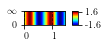

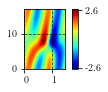

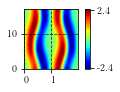

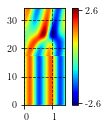

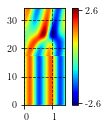


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [15, 14], "basis": "modes", "parameters": [34.302, 13.02, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial residual : 98.49974312213538
Target residual tolerance : 1e-06
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------
#################################################
 Residual=0.3894014 after 5000 adjoint descent steps. Parameters=(34.3764008735906, 13.018910020868976, 0.0)
#################################################
Maximum number of iterations reached. exiting with residual=0.2830576783196959


In [2]:
s = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/streak/final_tile/EquilibriumOrbitKS_L6p39.h5'
w = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/gap/final_tile/AntisymmetricOrbitKS_T17p150_L17p591.h5'
m = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/defects/defect1/final_tile/RelativeOrbitKS_T15p855_L13p026.h5'

with h5py.File(m, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    m = RelativeOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(w, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    w = AntisymmetricOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(s, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    s = EquilibriumOrbitKS(state=dat, parameters=params, basis='field')
    
d = read_h5('../data/local/thesis.h5', 'families/defect_large_family_member').transform(to='modes')

td = read_tileset('../data/ks/tiles.h5', (0, 1, 2),
                  ('/default/double_streak','/default/defect','/default/wiggle'),
                  validate=False)
td[0].plot()
td[1].plot()
td[2].plot()
# td[0] = td[0].cell_shift(4, axis=1)

tile(np.array([[1],[0]]), td, OrbitKS).plot()

orbit_1_2 = tile(np.array([[1],[0]]), td, OrbitKS)  
orbit_1_2.plot()
result_12 = hunt(orbit_1_2.resize(8, 8).resize(16, 16).transform(to='modes'), 
                     method='hybrid', verbose=True, pexp=(1,4), preconditioning=True, comp_time='long')

The first type of continuation is provided by ```continuation``` which imposes constraints on the dimensions, performing
a multi-stepped optimization process. To demonstrate this, the 'defect' fundamental periodic orbit is converted back into
a RelativeOrbitKS; it was saved as an OrbitKS without symmetry because of how tiling works. 

In [3]:
defect = convert_class(td[1], RelativeOrbitKS).reshape(16,16).transform(to='modes')
defect = converge(defect, method='lstsq', verbose=True).orbit

AttributeError: RelativeOrbitKS has no attribute'reshape'

The first demonstration is that temporal continuation, fixing the temporal period, can be used instead of spatial continuation
which is less likely to succeed, *if* the temporal period corresponding to the spatial size is known. For example, let's say that we are targeting $L=13.08$ for the defect tile.


In [2]:
# defect_spatial_continuation = dimension_continuation(defect, 13.08, step_size=0.025, axis=1, method='lstsq', verbose=True).orbit

In [ ]:
defect_spatial_continuation.plot()
defect_spatial_continuation

This can also be performed in time to the same domain size, in order to achieve the approximately same orbit.

In [8]:
defect_spatial_continuation.t, defect.constraints

10.110505916382113

In [9]:
defect.constraints

{'T': False, 'L': False, 'S': False}

In [3]:
# defect_temporal_continuation = dimension_continuation(defect, defect_spatial_continuation.T, step_size=8, axis=0,
#                                                       method='lstsq', verbose=True).orbit

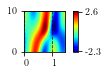

In [11]:
defect_temporal_continuation.plot()

It can also be useful to rediscretize and converge the result; this is accessible through ```discretization_continuation```;
provide the new field_shape and then the function will try to increment the discretization size by the specified amount;
the routine will always reshape in the most optimized manner, i.e. the smallest dimensions first.

if going from (16, 16)-> (32, 64), the shape goes to (16, 64) and then (32, 64) unless `cycle=True`, at which point discretization will cycle through the axes in order specified by the user via `axes_order` keyword argument.

For example: `axes_order=(1, 0)`, `initial_shape = (16, 16)`, `target_shape = (32, 64)` would rediscretize in sequence
(16, 18)->(18,18)->(18,20)-> ... -> (32, 64)

If, of course, the increment is specified to be 2 in each dimension.

In [4]:
# x = discretization_continuation(defect_temporal_continuation, (24, 24), step_sizes=(2,2), cycle=True, verbose=True)

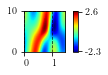

In [13]:
x.orbit.plot()

This is also automated through the ```span_family``` function. This function requires bounds, step_sizes, and the orbit to serve as the "root" of the branches.

In [12]:
roots

[RelativeOrbitKS({"shape": [26, 26], "basis": "field", "parameters": [17.151, 13.02, -3.313]}),
 RelativeOrbitKS({"shape": [26, 26], "basis": "field", "parameters": [8.43, 13.2, -3.943]}),
 AntisymmetricOrbitKS({"shape": [34, 34], "basis": "field", "parameters": [17.151, 17.591, 0.0]}),
 RelativeOrbitKS({"shape": [34, 34], "basis": "field", "parameters": [17.371, 17.568, -5.688]})]

In [13]:
keys = tuple(['defect', 'drifter', 'wiggle', 'large_defect'])


In [16]:
roots = read_h5('roots.h5')#.pop(1)
_ = roots.pop(1)

names = tuple(['/default/'+k for k in keys])
root_orbits_resized = []
for name, window in zip(keys, roots):
    window = window.transform(to='modes')
    resized_window = discretization_continuation(window, (32, 32), verbose=True,
                                                methods=('adj','lstsq'), tol=[1e-4, 1e-10], ftol=0,
                                                preconditioning=True, cycle=True).orbit
    root_orbits_resized.append(resized_window)
    # covering = [x.transform(to='field') for x in read_h5('small_cover.h5')]
    # base = read_h5('../../notebooks/large_trajectories.h5', '/1')


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [25, 24], "basis": "modes", "parameters": [17.151, 13.02, -3.313]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 2.538666545210359e-06
Target residual tolerance : 0.0001
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [25, 24], "basis": "modes", "parameters": [17.151, 13.02, -3.313]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 2.538666545210359e-06
Target residual tolerance : 1e-10
Maximum iteration number : 500
-------------------------------------------------------------------------------------------------

Converged. Exit


Converged. Exiting with residual=1.700461660054283e-18

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : RelativeOrbitKS({"shape": [25, 26], "basis": "modes", "parameters": [8.43, 13.2, -3.943]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 3.2480899713741783e-07
Target residual tolerance : 0.0001
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : RelativeOrbitKS({"shape": [25, 26], "basis": "modes", "parameters": [8.43, 13.2, -3.943]})
Constraints : {'t': False, 'x': False, 's': False}
Initial residual : 3.2480899713741783e-07
Target residual tolerance : 1e-10
Maximum iteration number : 500
--------------------------------------------------------------


Converged. Exiting with residual=3.93663396177051e-26

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.151, 17.591, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial residual : 1.2778209301075418e-16
Target residual tolerance : 0.0001
Maximum iteration number : 10000
-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial guess : AntisymmetricOrbitKS({"shape": [31, 15], "basis": "modes", "parameters": [17.151, 17.591, 0.0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial residual : 1.2778209301075418e-16
Target residual tolerance : 1e-10
Maximum iteration number : 500
-----------------------------------------------------

In [20]:
[x.residual() for x in root_orbits_resized]

[3.6998945199262864e-20,
 3.534352507098165e-23,
 1.2778329054972477e-16,
 2.6501390011327935e-11]

In [18]:
root_orbits_resized = [x.transform(to='field') for x in root_orbits_resized]
# for name, window in zip(keys, root_orbits_resized):
#     window.to_h5(filename='roots.h5', groupname=name)

In [17]:
root_orbits_resized = read_h5('roots.h5')

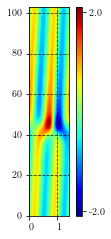

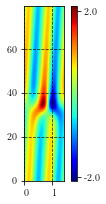

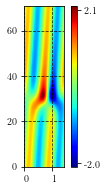

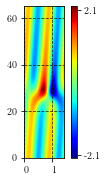

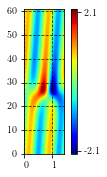

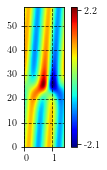

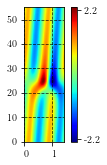

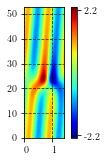

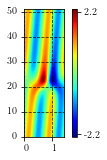

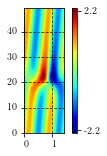

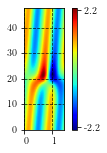

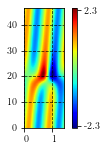

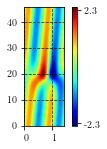

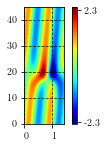

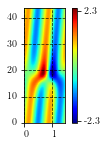

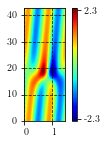

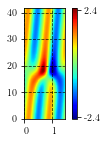

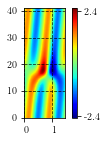

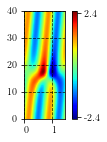

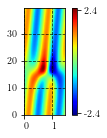

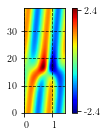

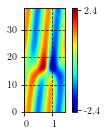

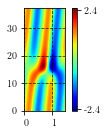

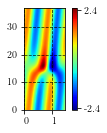

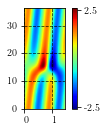

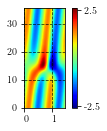

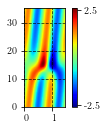

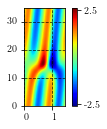

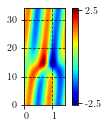

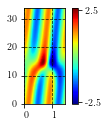

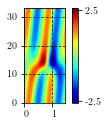

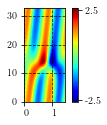

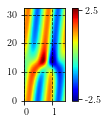

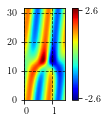

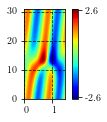

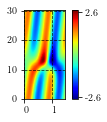

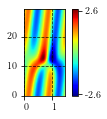

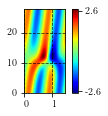

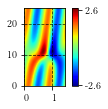

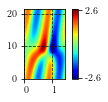

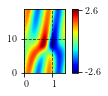

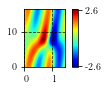

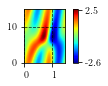

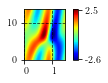

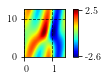

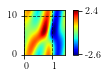

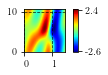

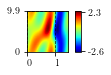

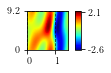

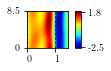

In [12]:
for x in sorted(read_h5('covering_xcont.h5', '/defect/'), key=lambda o : o.x):
    x.plot()

In [26]:
for name, window in zip(keys, root_orbits_resized):
    print(name)
    if name != 'streak':
        bounds = {'t': (window.t//2, 2*window.t)}
        step_sizes = {'t': 0.01}
        window = hunt(window.transform(to='modes'), methods='lstsq', tol=1e-10).orbit
        span_family(window, bounds=bounds, step_sizes=step_sizes, tol=[1e-4, 1e-6], maxiter=[25000, 100], sampling_rate=10,
                verbose=False, methods=('adj', 'lstsq'), ftol=0, preconditioning=True,
                filename='covering.h5', groupname=name, h5mode='a')
#     else:
#         bounds = {'x': (0, 100)}
#         step_sizes = {'x': 0.1}     
#         window = hunt(window.transform(to='modes').resize(1, 12), methods='lstsq', tol=1e-10).window
#         span_family(window, bounds=bounds, step_sizes=step_sizes, tol=[1e-4, 1e-6], maxiter=[25000, 100],
#                 verbose=False, methods=('adj', 'lstsq'), ftol=0, preconditioning=True,
#                 filename='covering.h5', groupname=name, h5mode='a')

defect
drifter
wiggle
large_defect


In [42]:
new_covering = read_h5('covering.h5')

In [35]:
new_covering = [[x.transform(to='field') for x in families] for families in new_covering]

#####################


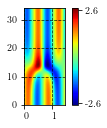

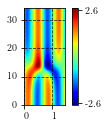

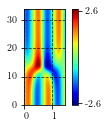

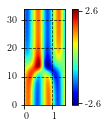

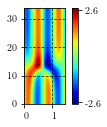

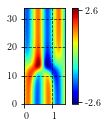

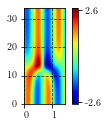

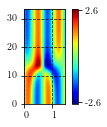

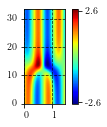

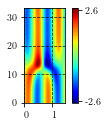

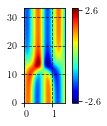

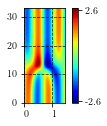

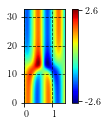

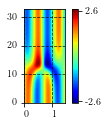

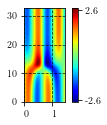

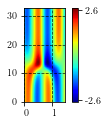

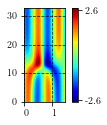

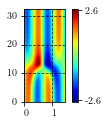

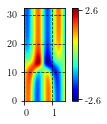

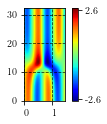

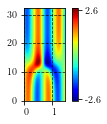

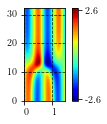

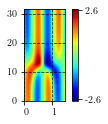

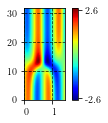

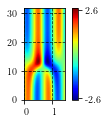

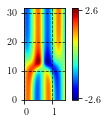

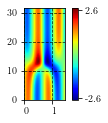

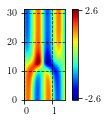

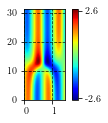

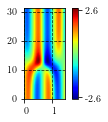

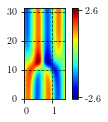

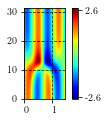

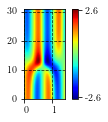

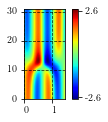

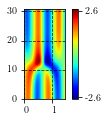

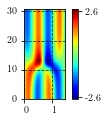

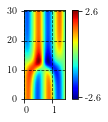

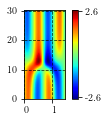

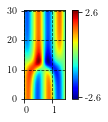

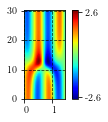

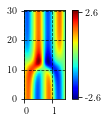

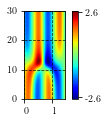

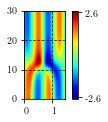

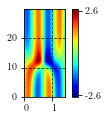

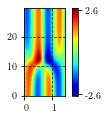

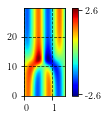

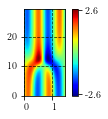

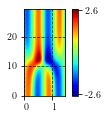

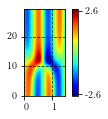

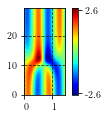

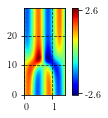

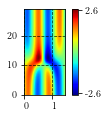

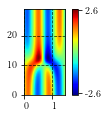

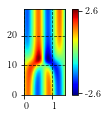

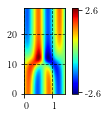

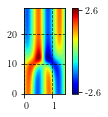

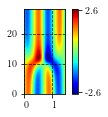

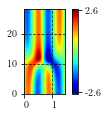

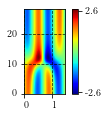

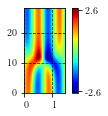

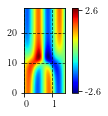

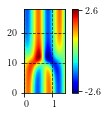

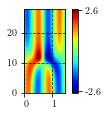

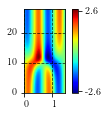

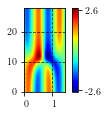

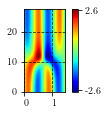

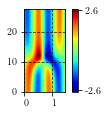

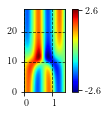

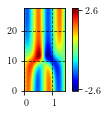

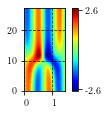

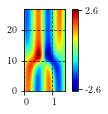

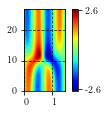

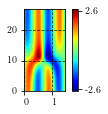

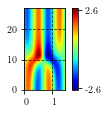

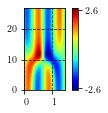

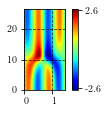

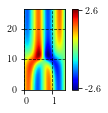

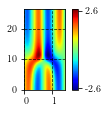

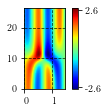

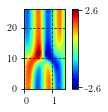

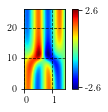

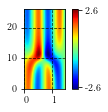

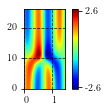

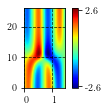

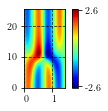

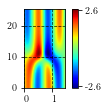

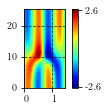

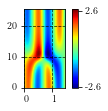

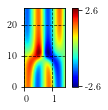

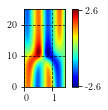

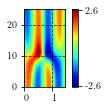

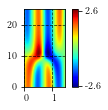

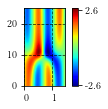

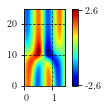

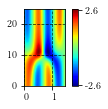

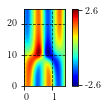

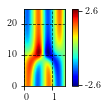

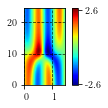

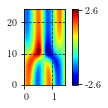

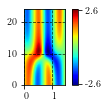

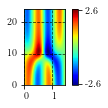

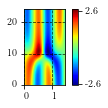

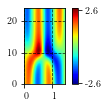

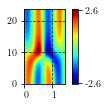

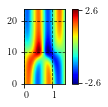

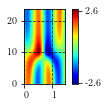

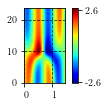

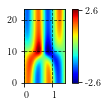

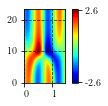

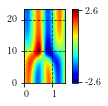

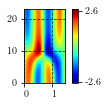

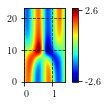

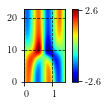

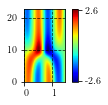

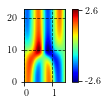

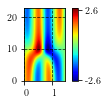

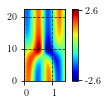

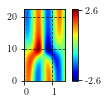

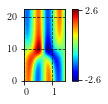

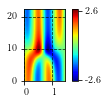

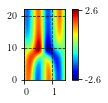

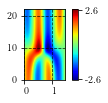

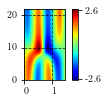

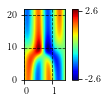

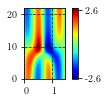

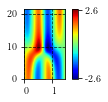

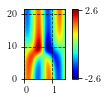

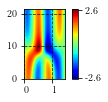

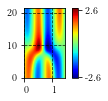

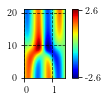

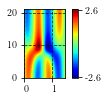

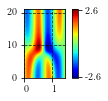

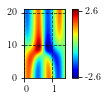

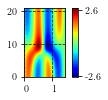

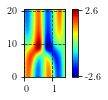

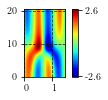

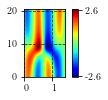

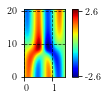

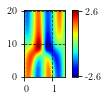

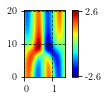

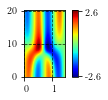

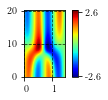

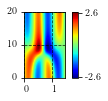

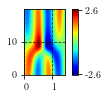

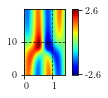

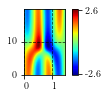

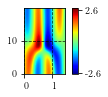

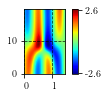

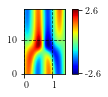

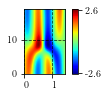

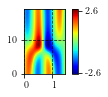

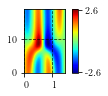

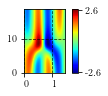

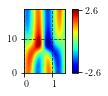

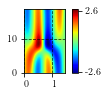

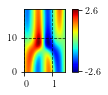

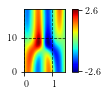

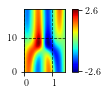

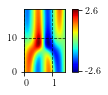

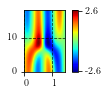

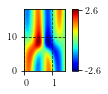

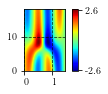

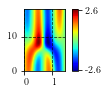

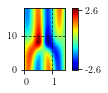

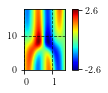

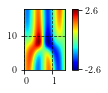

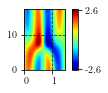

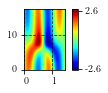

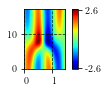

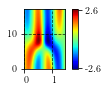

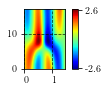

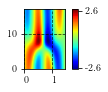

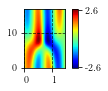

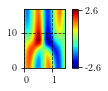

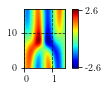

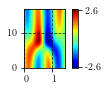

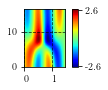

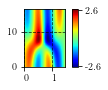

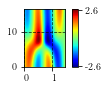

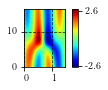

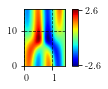

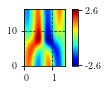

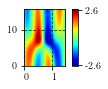

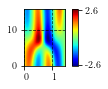

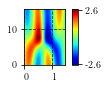

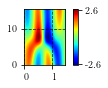

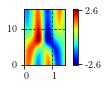

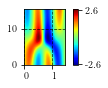

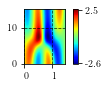

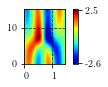

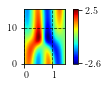

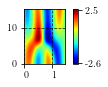

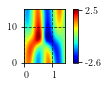

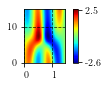

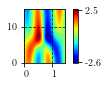

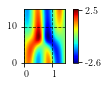

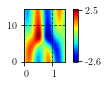

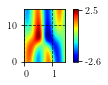

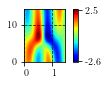

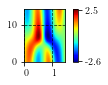

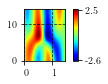

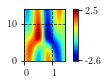

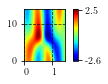

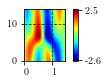

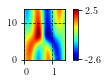

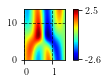

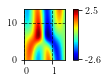

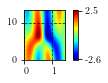

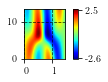

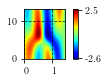

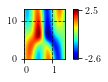

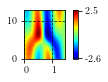

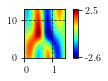

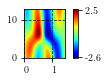

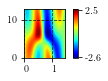

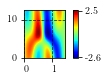

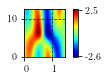

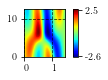

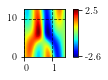

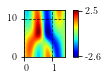

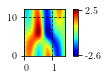

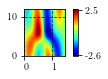

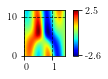

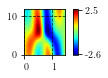

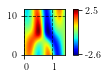

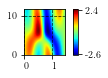

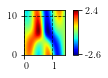

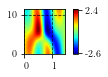

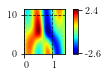

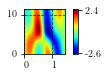

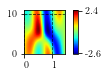

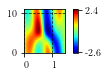

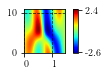

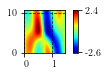

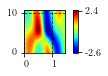

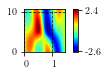

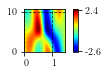

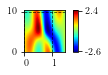

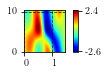

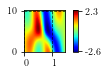

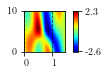

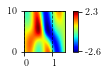

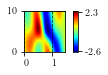

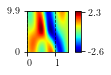

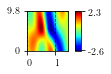

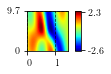

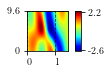

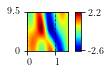

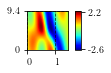

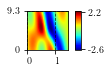

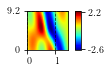

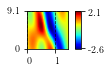

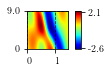

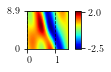

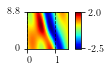

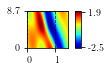

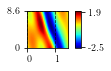

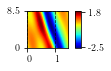

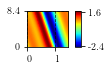

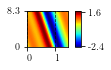

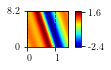

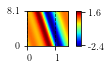

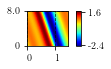

#####################


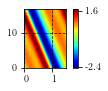

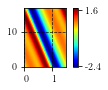

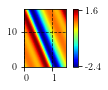

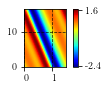

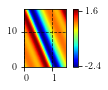

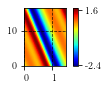

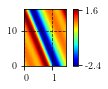

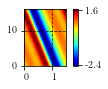

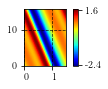

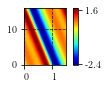

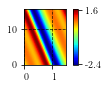

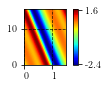

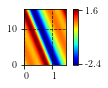

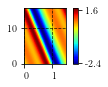

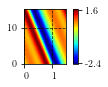

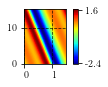

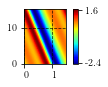

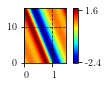

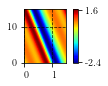

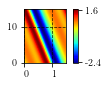

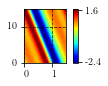

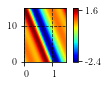

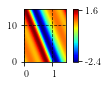

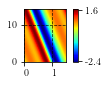

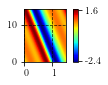

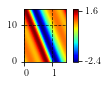

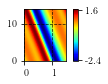

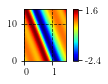

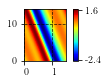

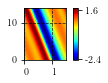

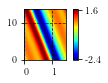

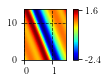

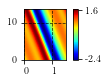

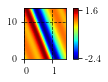

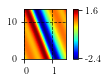

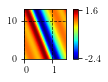

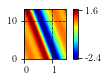

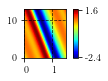

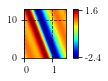

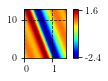

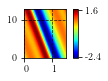

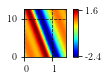

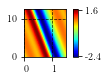

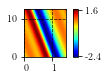

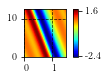

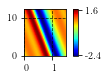

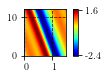

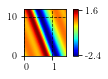

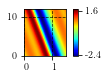

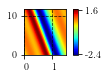

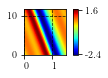

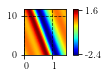

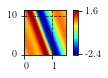

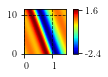

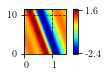

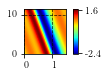

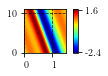

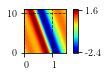

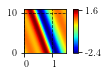

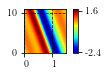

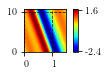

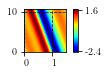

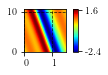

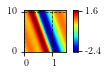

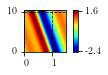

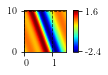

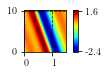

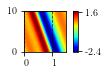

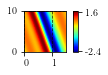

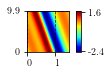

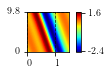

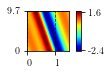

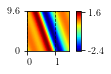

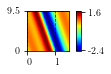

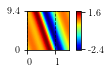

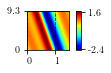

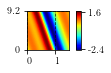

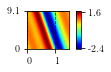

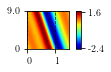

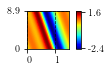

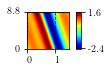

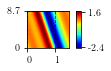

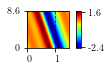

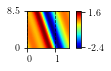

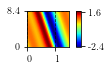

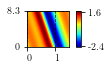

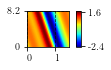

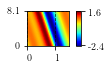

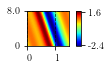

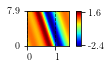

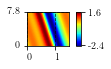

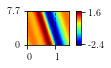

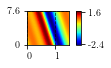

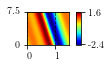

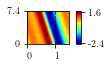

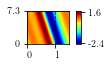

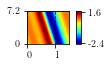

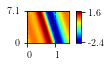

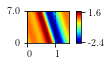

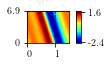

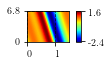

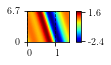

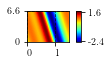

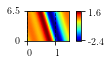

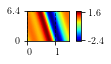

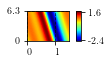

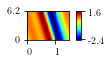

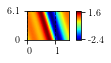

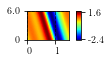

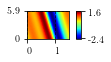

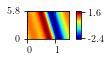

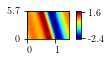

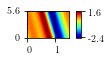

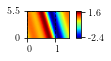

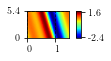

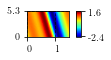

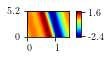

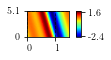

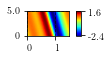

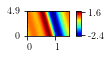

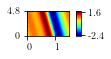

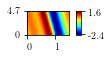

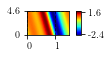

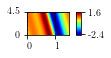

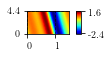

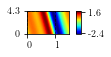

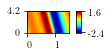

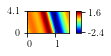

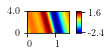

#####################


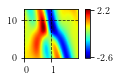

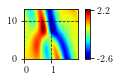

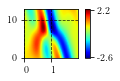

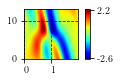

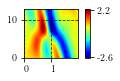

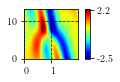

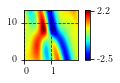

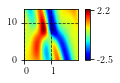

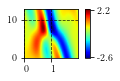

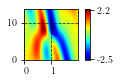

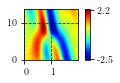

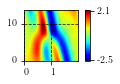

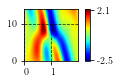

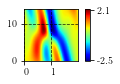

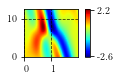

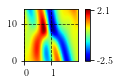

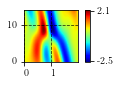

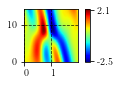

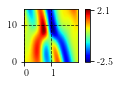

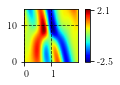

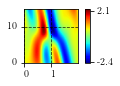

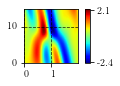

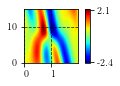

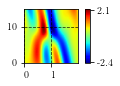

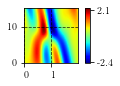

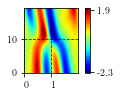

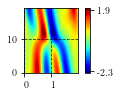

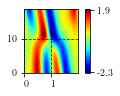

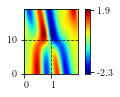

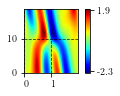

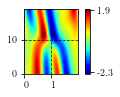

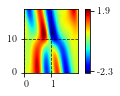

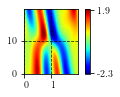

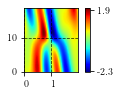

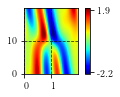

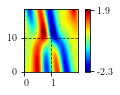

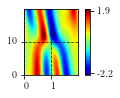

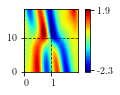

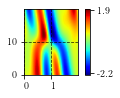

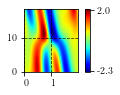

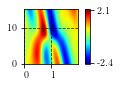

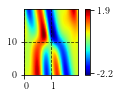

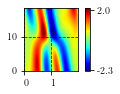

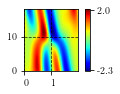

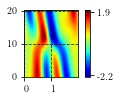

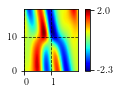

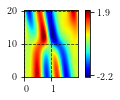

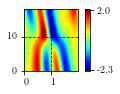

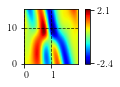

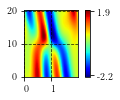

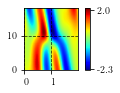

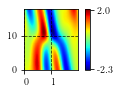

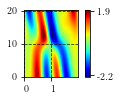

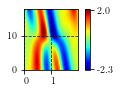

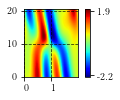

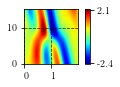

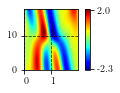

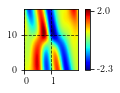

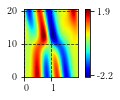

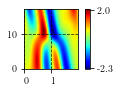

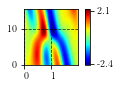

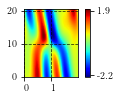

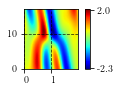

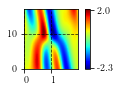

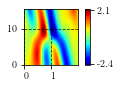

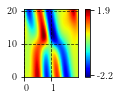

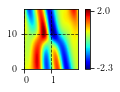

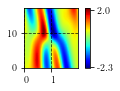

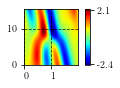

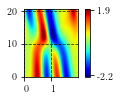

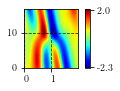

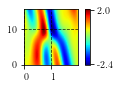

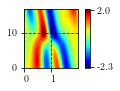

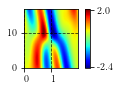

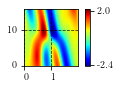

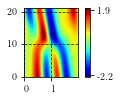

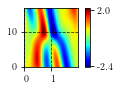

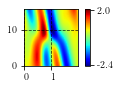

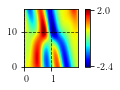

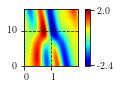

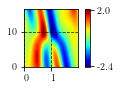

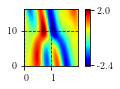

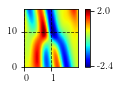

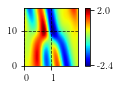

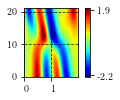

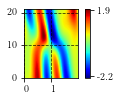

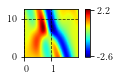

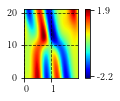

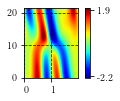

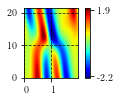

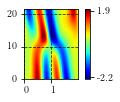

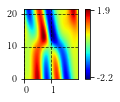

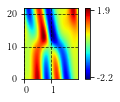

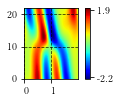

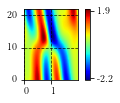

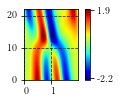

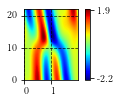

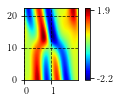

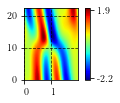

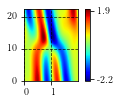

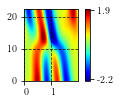

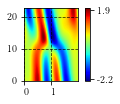

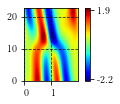

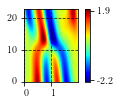

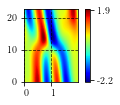

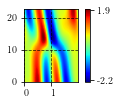

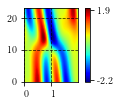

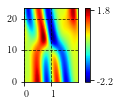

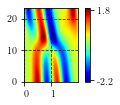

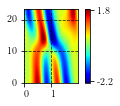

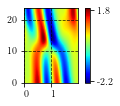

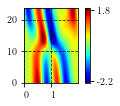

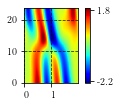

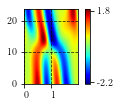

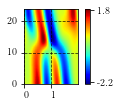

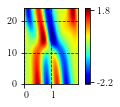

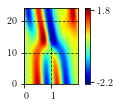

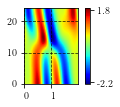

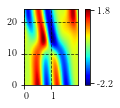

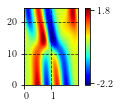

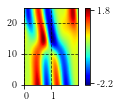

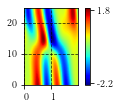

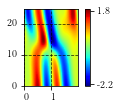

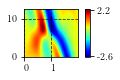

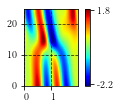

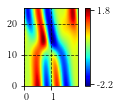

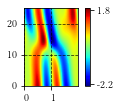

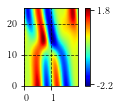

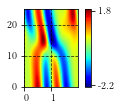

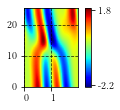

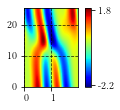

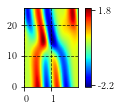

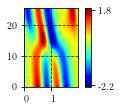

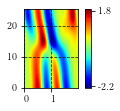

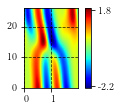

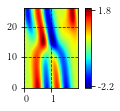

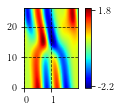

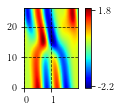

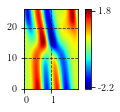

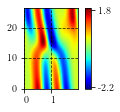

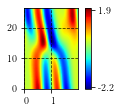

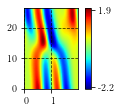

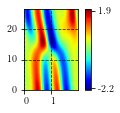

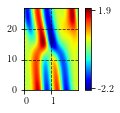

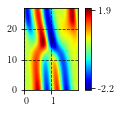

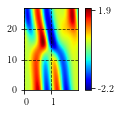

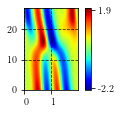

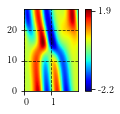

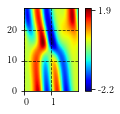

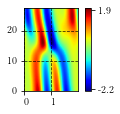

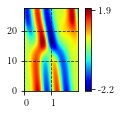

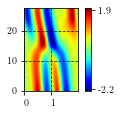

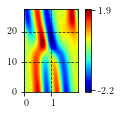

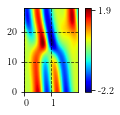

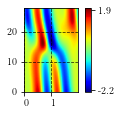

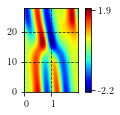

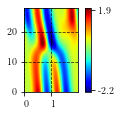

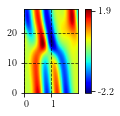

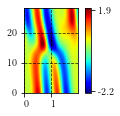

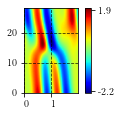

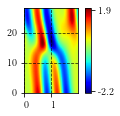

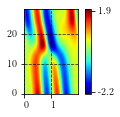

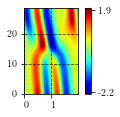

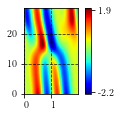

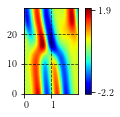

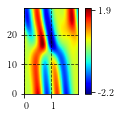

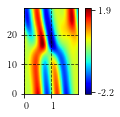

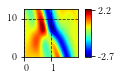

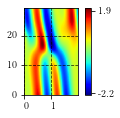

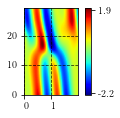

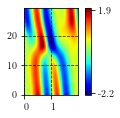

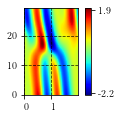

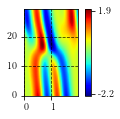

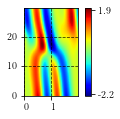

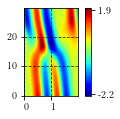

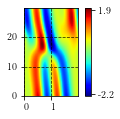

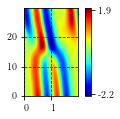

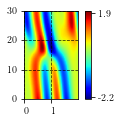

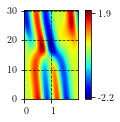

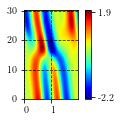

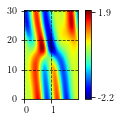

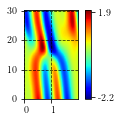

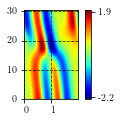

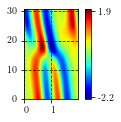

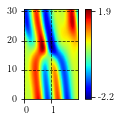

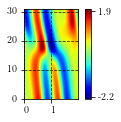

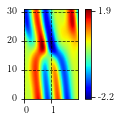

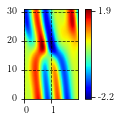

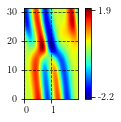

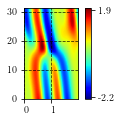

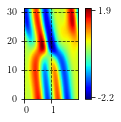

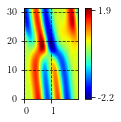

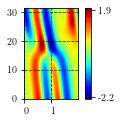

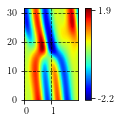

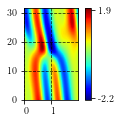

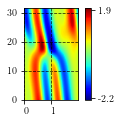

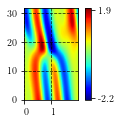

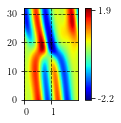

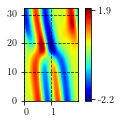

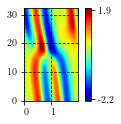

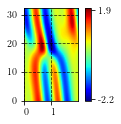

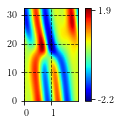

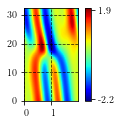

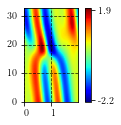

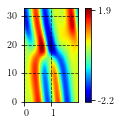

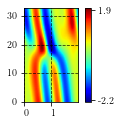

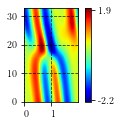

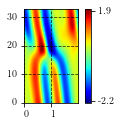

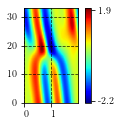

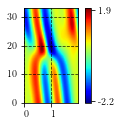

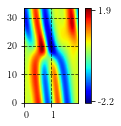

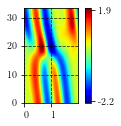

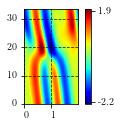

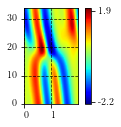

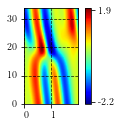

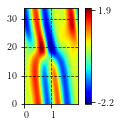

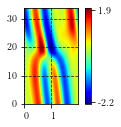

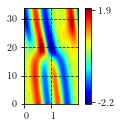

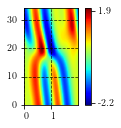

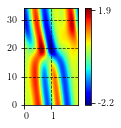

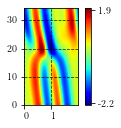

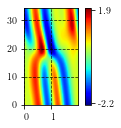

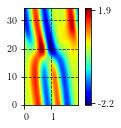

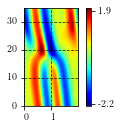

#####################


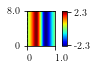

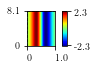

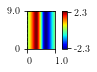

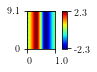

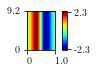

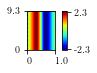

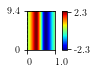

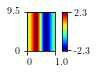

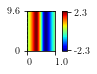

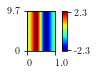

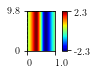

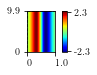

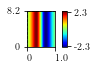

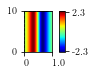

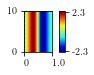

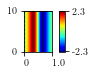

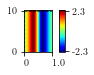

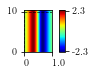

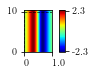

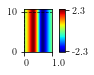

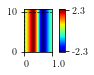

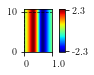

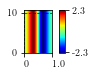

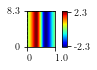

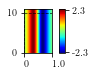

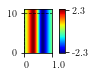

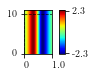

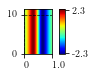

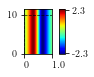

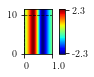

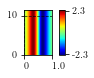

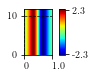

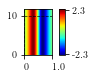

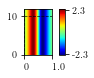

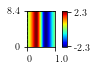

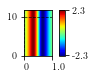

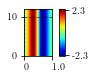

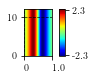

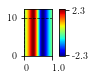

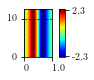

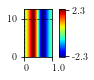

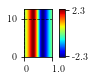

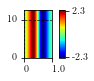

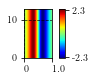

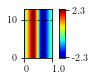

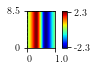

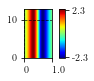

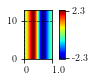

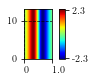

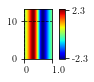

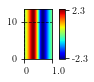

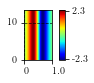

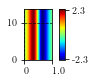

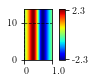

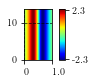

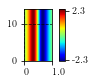

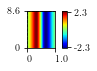

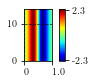

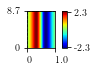

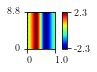

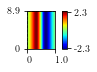

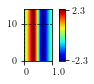

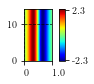

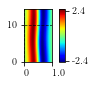

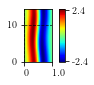

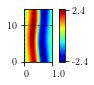

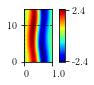

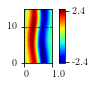

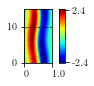

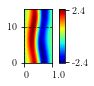

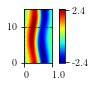

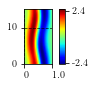

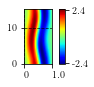

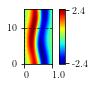

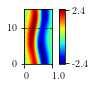

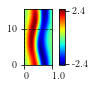

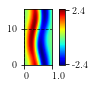

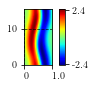

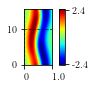

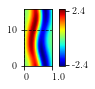

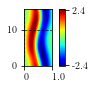

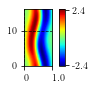

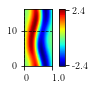

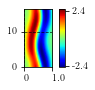

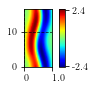

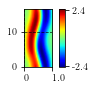

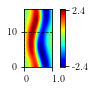

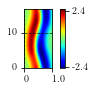

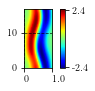

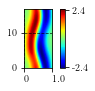

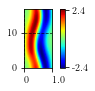

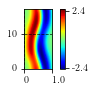

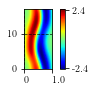

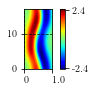

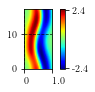

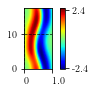

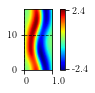

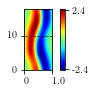

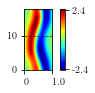

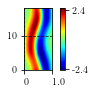

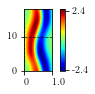

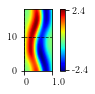

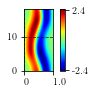

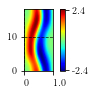

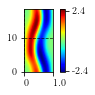

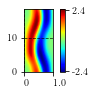

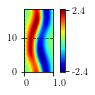

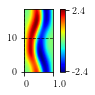

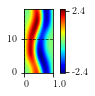

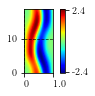

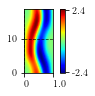

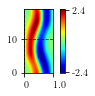

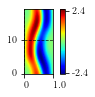

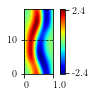

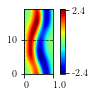

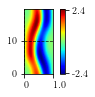

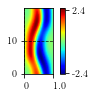

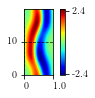

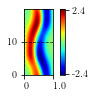

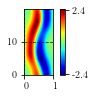

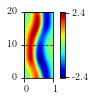

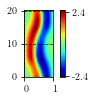

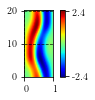

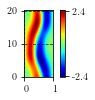

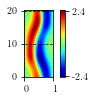

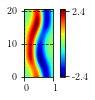

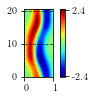

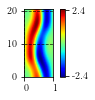

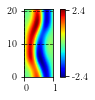

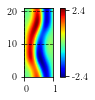

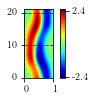

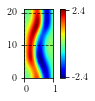

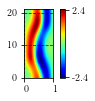

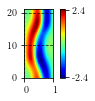

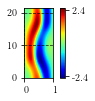

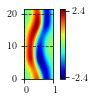

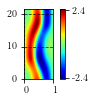

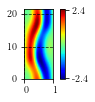

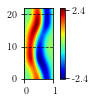

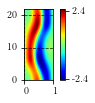

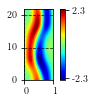

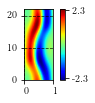

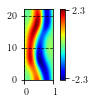

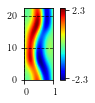

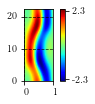

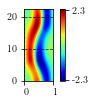

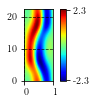

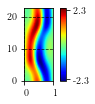

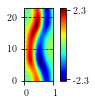

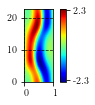

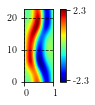

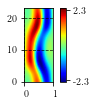

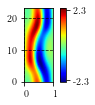

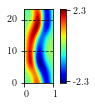

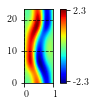

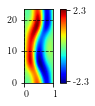

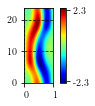

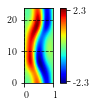

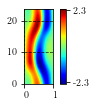

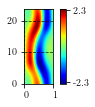

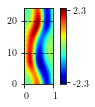

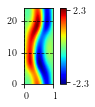

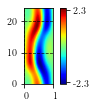

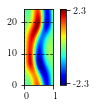

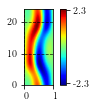

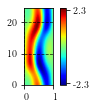

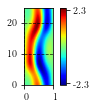

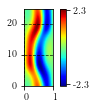

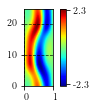

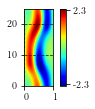

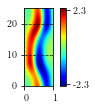

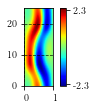

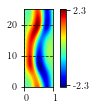

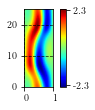

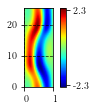

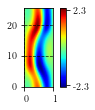

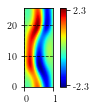

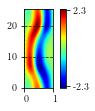

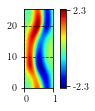

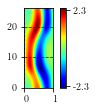

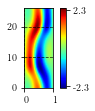

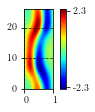

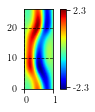

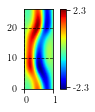

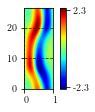

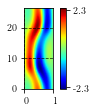

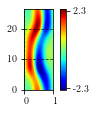

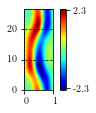

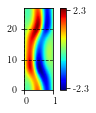

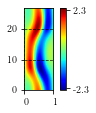

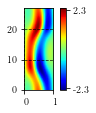

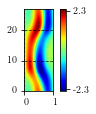

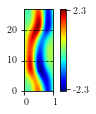

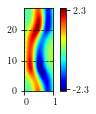

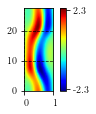

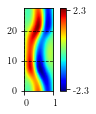

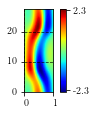

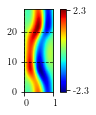

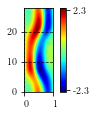

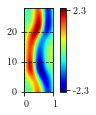

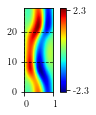

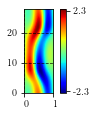

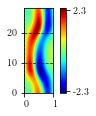

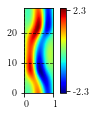

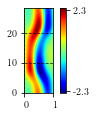

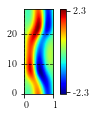

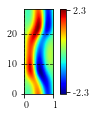

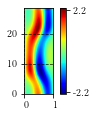

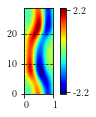

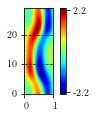

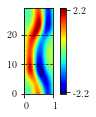

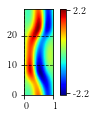

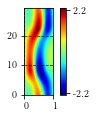

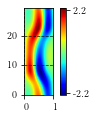

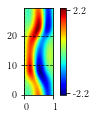

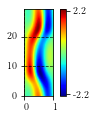

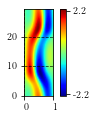

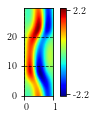

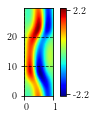

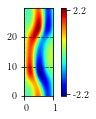

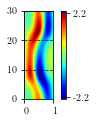

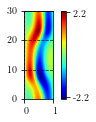

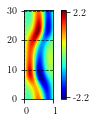

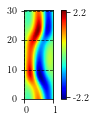

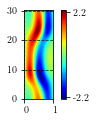

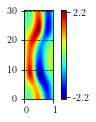

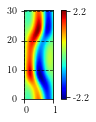

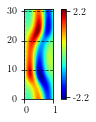

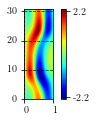

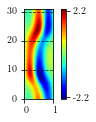

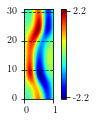

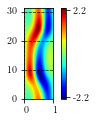

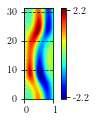

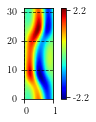

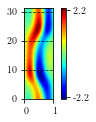

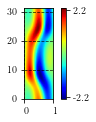

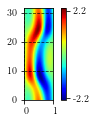

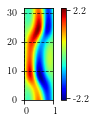

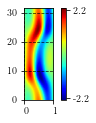

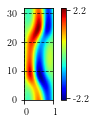

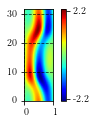

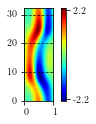

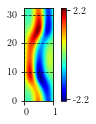

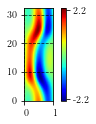

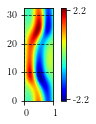

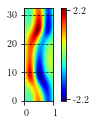

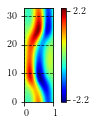

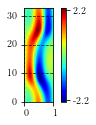

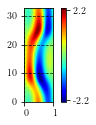

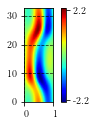

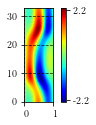

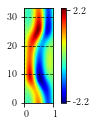

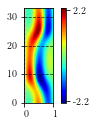

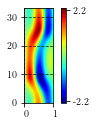

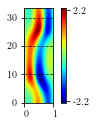

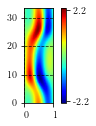

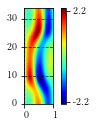

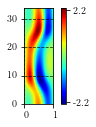

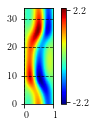

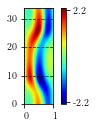

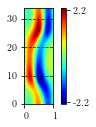

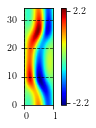

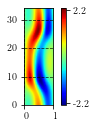

In [41]:
for y in new_covering:
    print('#####################')
    for x in sorted(y, key=lambda x : x.x):
        x.plot(fundamental_domain=True)

In [41]:
old_wiggles = read_h5('covering.h5', 'wiggle/')

In [38]:
wiggles = read_h5('wiggle.h5')
for w in wiggles:
    if w.t >old_wiggles[-1].t:
        w.to_h5('covering.h5', groupname='wiggle')

In [51]:
# [defect_family, drifter_family,large_defect_family,streak_family, wiggle_family]
keys = tuple(['defect', 'drifter', 'large_defect', 'wiggle'])
for k in keys:
    fam = read_h5('covering.h5', k+'/')
    for f in fam:
        if k == 'wiggle':
            if f.t >= 10:
                f.to_h5('covering_redo.h5', groupname=k, verbose=True)          
        else:
            if f.t > 0.:
                f.to_h5('covering_redo.h5', groupname=k, verbose=True)
            if k == 'streak':
                if f.norm() > 1e-2:
                    f.to_h5('covering_redo.h5', groupname=k, verbose=True)                

Writing dataset "defect/0" to file covering_redo.h5
Writing dataset "defect/1" to file covering_redo.h5
Writing dataset "defect/2" to file covering_redo.h5
Writing dataset "defect/3" to file covering_redo.h5
Writing dataset "defect/4" to file covering_redo.h5
Writing dataset "defect/5" to file covering_redo.h5
Writing dataset "defect/6" to file covering_redo.h5
Writing dataset "defect/7" to file covering_redo.h5
Writing dataset "defect/8" to file covering_redo.h5
Writing dataset "defect/9" to file covering_redo.h5
Writing dataset "defect/10" to file covering_redo.h5
Writing dataset "defect/11" to file covering_redo.h5
Writing dataset "defect/12" to file covering_redo.h5
Writing dataset "defect/13" to file covering_redo.h5
Writing dataset "defect/14" to file covering_redo.h5
Writing dataset "defect/15" to file covering_redo.h5
Writing dataset "defect/16" to file covering_redo.h5
Writing dataset "defect/17" to file covering_redo.h5
Writing dataset "defect/18" to file covering_redo.h5
Wri

Writing dataset "large_defect/32" to file covering_redo.h5
Writing dataset "large_defect/33" to file covering_redo.h5
Writing dataset "large_defect/34" to file covering_redo.h5
Writing dataset "large_defect/35" to file covering_redo.h5
Writing dataset "large_defect/36" to file covering_redo.h5
Writing dataset "large_defect/37" to file covering_redo.h5
Writing dataset "large_defect/38" to file covering_redo.h5
Writing dataset "large_defect/39" to file covering_redo.h5
Writing dataset "large_defect/40" to file covering_redo.h5
Writing dataset "large_defect/41" to file covering_redo.h5
Writing dataset "large_defect/42" to file covering_redo.h5
Writing dataset "large_defect/43" to file covering_redo.h5
Writing dataset "large_defect/44" to file covering_redo.h5
Writing dataset "large_defect/45" to file covering_redo.h5
Writing dataset "large_defect/46" to file covering_redo.h5
Writing dataset "large_defect/47" to file covering_redo.h5
Writing dataset "large_defect/48" to file covering_redo.

Writing dataset "wiggle/103" to file covering_redo.h5
Writing dataset "wiggle/104" to file covering_redo.h5
Writing dataset "wiggle/105" to file covering_redo.h5
Writing dataset "wiggle/106" to file covering_redo.h5
Writing dataset "wiggle/107" to file covering_redo.h5
Writing dataset "wiggle/108" to file covering_redo.h5
Writing dataset "wiggle/109" to file covering_redo.h5
Writing dataset "wiggle/110" to file covering_redo.h5
Writing dataset "wiggle/111" to file covering_redo.h5
Writing dataset "wiggle/112" to file covering_redo.h5
Writing dataset "wiggle/113" to file covering_redo.h5
Writing dataset "wiggle/114" to file covering_redo.h5
Writing dataset "wiggle/115" to file covering_redo.h5
Writing dataset "wiggle/116" to file covering_redo.h5
Writing dataset "wiggle/117" to file covering_redo.h5
Writing dataset "wiggle/118" to file covering_redo.h5
Writing dataset "wiggle/119" to file covering_redo.h5
Writing dataset "wiggle/120" to file covering_redo.h5
Writing dataset "wiggle/121"

In [ ]:
for base_num in range(kwargs.get('n_trajectories', 1319)):
    base = read_h5('../notebooks/large_trajectory.h5', '/'+str(int(base_num)))
    tmp = base.resize(int(2*((base.x/dx)//2)), int(2*((base.x/dx)//2))).transform(to='field')
    small_patch = base.__class__(state=tmp.state[352:-352,352:-352], parameters=(dx*128, dt*128,0),basis='field')
#     small_patch.plot(padding=False)
    small_patch.to_h5('small_patches.h5',verbose=True)

for base_num in range(kwargs.get('n_trajectories', 1000)):
    base = read_h5('../notebooks/large_trajectory.h5', '/'+str(int(base_num)))
    tmp = base.resize(int(2*((base.x/dx)//2)), int(2*((base.x/dx)//2))).transform(to='field')
    patch = base.__class__(state=tmp.state[288:-288,288:-288], parameters=(dx*256, dt*256,0),basis='field')
    patch.to_h5('patches.h5',verbose=True)